# Introduction
In this notebook, we compare the performance of several non-transformer model(s) for single-label classification of the Huffington Post news dataset.

The news headlines from the dataset are used as input texts, from which we derive numerical representations using the Term Frequency - Inverse Document Frequency method. TF-IDF is a 'Bag of Words' approach to engineering text features. 

We compare the baseline of the Naive Bayes classifier with: 
- Random Forest
- Logistic Regression
- Support Vector Machine (Linear Support Vector Classifier)

By using k-fold cross-validation, we select the best preliminary model for further hyperparameter tuning, and also test some techniques such as random oversampling to mitigate the imbalance in the dataset categories.


## Dataset
Huffington News headline texts downloaded from https://www.kaggle.com%2Fdatasets%2Frmisra%2Fnews-category-dataset%2Fdata.

Exploratory analysis of this is in the huffpost-news-EDA notebook.

TODO: The baseline can serve as a benchmark for comparison with a transformer classifier to determine if a transformer model Huggingface's DistilBERT can perform better than non-transformer models in an NLP single-label classification of an imbalanced dataset.

TODO: Using Huggingface's Pytorch Trainer API to fine-tune DistilBERT

Possible data treatments:
(1) None: use imbalanced dataset as is for both types of models to see if transformers have any advantages over non-transformer models for imbalanced data
(2) Oversampling of minority classes
(3) Undersampling of majority classes

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# import transformers
# print(transformers.__version__)
# from transformers import Trainer


In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

# (A) Dataset
- The dataset has been filtered to include only categories with 5000 or more records. 
- For a start, this cutoff was applied to see how well classifiers can be optimised for such an imbalanced dataset. 
- Also the dataset contains only text that are without emoji's or emoticons. 
- Total ~ 135K rows

In [3]:
# root = r"/content" # For Google colab notebook: "/content/data_processed_12cats.csv"
root = r"/Users/cathytay/60-69-Code/61.06-TextClassification/data" #r"/data" # For github (else change to point to local path)
data = pd.read_csv(os.path.join(root, r"data_processed_12cats.csv"), usecols=['text', 'category'])#, encoding='utf-8') 
data.rename(columns={'headline':'text', 'category':'label'}, inplace=True)

In [4]:
# Load dataset (get text and target columns only)
len(data)

134861

In [4]:
# Drop rows which have null text
df1 = data.loc[data['text'].isna()!=True]
len(df1)

134861

In [29]:
print(f"Number of categories: {data['label'].nunique()}\n")

ct = df1.label.value_counts().rename_axis('label').reset_index(name='count')
ct['percent'] = ((ct['count']/ct['count'].sum())*100).round(2)
ct

Number of categories: 12



,label,count,percent
0,POLITICS,35530,26.35
1,WELLNESS,17945,13.31
2,ENTERTAINMENT,17203,12.76
3,TRAVEL,9863,7.31
4,STYLE & BEAUTY,9811,7.27
5,PARENTING,8791,6.52
6,HEALTHY LIVING,6673,4.95
7,FOOD & DRINK,6340,4.70
8,QUEER VOICES,6293,4.67
9,BUSINESS,5984,4.44


There are 3 major categories that account for more than 51% of the dataset:
- Politics (26.4%)
- Wellness (13.3%)
- Entertainment (12.8%)

The remaining 48% of the data consists of 9 minor categories.

In [6]:
# Function to keep the categories with a minimum number (n) of entries
# we can use this function later to trim the dataset by adjusting the minimum threshold
cat_counts = data['label'].value_counts()

def cat_dropper(df, n):
  '''
  Takes in a dataframe, and a minimum number (n) of entries required for categories
  Drops rows belonging to categories that have less than n entries in the dataframe
  Returns dataframe with categories that have n or more entries

  '''
  df1 = df.loc[df['label'].isin(cat_counts[cat_counts >= n].index)]
  print(f"Number of rows dropped = {len(df)- len(df1)}")
  return df1

In [8]:
df1 = cat_dropper(data, 5000)
df1.info() # 135261 rows

Number of rows dropped = 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 134861 entries, 0 to 134860
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   134861 non-null  object
 1   text    134861 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [6]:
pd.set_option('display.max_colwidth', None)
df1.loc[26971] # quotes are displayed fine

label                                                                                                                                           POLITICS
text     Ruth Bader Ginsburg Is Confident We'll Get Out Of This Mess The Women's March is "reason to hope that that we will see a better day," she said.
Name: 26971, dtype: object

# (B) Processing dataset for training

In [9]:
# Write a dataframe processor function
class Processor:
  """
  A class to process a dataframe containing text and category label columns
  to produce label-to-id dictionaries for mapping category labels to numerical label id's.
  """
  def __init__(self, df):
    # List classes present
    self.classes = np.unique(df['label']).tolist()
    # Make dictionaries for category labels to id's
    self.id2label = {id:label for id,label in enumerate(self.classes)}
    self.label2id = {id:label for label,id in enumerate(self.classes)}

  # Map category labels to their id's
  def map_id(self, df):
    df.loc[:,'label_id'] = df['label'].map(lambda x: self.label2id[x.strip()])
    return df

In [10]:
p = Processor(df1)
df1 = p.map_id(df1)
df1.head(3)

,label,text,label_id
0,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,1
1,PARENTING,The Funniest Tweets From Parents This Week (Se...,5
2,SPORTS,"Maury Wills, Base-Stealing Shortstop For Dodge...",8


In [11]:
# Dictionary of numerical id's mapping to category labels
p.id2label

{0: 'BUSINESS',
 1: 'COMEDY',
 2: 'ENTERTAINMENT',
 3: 'FOOD & DRINK',
 4: 'HEALTHY LIVING',
 5: 'PARENTING',
 6: 'POLITICS',
 7: 'QUEER VOICES',
 8: 'SPORTS',
 9: 'STYLE & BEAUTY',
 10: 'TRAVEL',
 11: 'WELLNESS'}

In [12]:
# Make lists of text data and label_id's
text = df1['text'].tolist()
labels = df1['label_id'].tolist()

In [13]:
# Partition into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, stratify=y_train, random_state=RANDOM_STATE)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(86310, 26973, 86310, 26973)

# (C) Feature engineering with TF-IDF
- Here we extract features from the text data in the form of numerical representations or vectors, before feeding these as inputs to a machine learning algorithm. The vectorisation method chosen is Term-Frequency-Inverse Document Frequency (TF-IDF)
- TF-IDF reflects how important a word (or term) is to a document, relative to the entire collection (corpus) of documents. 
- TF-IDF = **term frequency (TF)** * **inverse document frequency (IDF)**.
- TF measures how often a term occurs in a single document, while IDF measures the relative frequency of that term across all documents of the collection. 
- If a term is very common in the entire collection of documents, then its IDF value becomes quite low; it is likely that the term does not correlate with any particular category or topic. However, if a term is quite rare across the whole corpus, the IDF value becomes higher for that term. If its term frequency is higher in certain categories of documents (i.e. it is quite common in those categories), that term may be a 'diagnostic' indicator of those categories.

- The higher the TF-IDF score, the more relevant the term is to a document.
- When we do TF-IDF vectorisation, we are calculating the TF-IDF for every word in a document, relative to the entire collection of documents. These TF-IDF values are entered into a vector for each document.
- We can then compare the vectors of two documents, to see how similar the vectors (and hence the documents) are using the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) method.

More on TF-IDF: https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/#:~:text=TF-IDF%20stands%20for%20term,documents%20


For a start, we use default TF-IDF parameters to vectorise the news headlines for baseline establishment. Although in theory, IDF should corrects for common words ("stop-words") such as 'a', 'of', but the sklearn package also has the option to remove these common English stop-words altogether from the documents. Presumably this lowers the background noise, hence this will be done below: 

In [15]:
# Make numerical representations of text data: TF-IDF
tfidf_params = dict(sublinear_tf=True, # scales term frequency to log scale (replaces tf with 1+log(tf))
                    min_df=5, # when building vocabulary, removes words that occur less than min_df number of files in corpus
                    ngram_range=(1,2), # upper and lower boundary of range of n values for n-gram extraction
                    stop_words='english', # passes the list of stop words to be removed
                    smooth_idf=True, # smooth idf weights by adding 1 to document frequencies (as if there's an extra document that contains every term in the collection once); prevents zero division error
                    norm='l2', #optional: this normalizes term vectors, 'None' for no normalization
                    )

tfidf = TfidfVectorizer(**tfidf_params)

In [16]:
features = tfidf.fit_transform(text).toarray() # Learn vocabulary and return tfidf matrix
print(f'{features.shape[0]} data rows represented by {features.shape[1]} features.')

134861 data rows represented by 61371 features.


After vectorising all the 135K rows of input texts, we see they can be represented by a total of 61K features, i.e. vocabulary words. 

In [71]:
df1.iloc[0]['text']

'23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23) "Until you have a dog you don\'t understand what could be eaten."'

In [74]:
# Adapted from https://python.plainenglish.io/how-to-use-tf-idf-to-retrieve-most-significant-words-of-a-file-a-practical-python-guide-1c0426ba9567
# Fit and transform the text
# text1 = text[:13486] # check for 10% of dataset (23s)
tfidf_matrix = tfidf.fit_transform(text) 

# Get feature names (words) and their corresponding TF-IDF scores
feature_names = tfidf.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

# Evaluate the most important words per film
important_words_ls = []
for i, score in enumerate(tfidf_scores):
    # Sort words by TF-IDF scores and select the top 5
    important_words = [word for word, score in
                        sorted(zip(feature_names, score), key=lambda x: x[1], reverse=True)[:5]]
    important_words_str = ", ".join(important_words)
    article = df1.iloc[i]["text"]
    important_words_ls.append({"article": article, "words": important_words_str})

# 40 min for 135K rows

In [75]:
# Browse lists of important word features for each article
important_words_ls[:10]

[{'article': '23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23) "Until you have a dog you don\'t understand what could be eaten."',
  'words': '23, 17 23, dogs week, tweets cats, cats dogs'},
 {'article': 'The Funniest Tweets From Parents This Week (Sept. 17-23) "Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce."',
  'words': 'tabasco, 17 23, reaper, toothbrush, screamed'},
 {'article': 'Maury Wills, Base-Stealing Shortstop For Dodgers, Dies At 89 Maury Wills, who helped the Los Angeles Dodgers win three World Series titles with his base-stealing prowess, has died.',
  'words': 'dodgers, stealing, base, shortstop, angeles dodgers'},
 {'article': 'Golden Globes Returning To NBC In January After Year Off-Air For the past 18 months, Hollywood has effectively boycotted the Globes after reports that the HFPA’s 87 members of non-American journalists included no Blac

In [14]:
# Make classification pipeline: vectorise data, then pass as inputs to train a model
clf = Pipeline(steps=[
    ('features', TfidfVectorizer(**tfidf_params)),
    ('model', MultinomialNB())
    ])

# Fit the pipeline to data (training the model)
clf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words='english', sublinear_tf=True)),
                ('model', MultinomialNB())])

In [15]:
# Classifier metrics
def classifier_metrics(y_pred, y_true, id2label, classes):
  """
  Takes lists of predictions of label id's and their true id's.
  Returns confusion matrix and classification report, with the id's mapped to their labels, (as defined by id2label and label2id dictionaries)
  """
  result = pd.DataFrame(columns=['y_pred_id', 'y_pred'])
  result.loc[:, 'y_pred_id'] = y_pred
  result.loc[:, 'y_pred'] = result['y_pred_id'].map(id2label)
  result.loc[:, 'y_true_id'] = y_true
  result.loc[:, 'y_true'] = result['y_true_id'].map(id2label)
  print(result)

  cm = confusion_matrix(result['y_true'], result['y_pred'], labels=classes)
  display = ConfusionMatrixDisplay(cm, display_labels=classes).plot()
  plt.xticks(rotation=70)
  plt.show()
  print(classification_report(
      y_true=result['y_true'], y_pred=result['y_pred'],
      labels=classes, zero_division=True))
  return result, cm

# (D) Baseline: Naive Bayes Classifier

In [78]:
# Make classification pipeline: vectorise data, then pass as inputs to train a model
clf = Pipeline(steps=[
    ('features', TfidfVectorizer(**tfidf_params)),
    ('model', MultinomialNB())
    ])

# Fit the pipeline to data (training the model)
clf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words='english', sublinear_tf=True)),
                ('model', MultinomialNB())])

In [16]:
# Use trained model to predict on test data
y_pred = clf.predict(X_test)

       y_pred_id         y_pred  y_true_id         y_true
0             11       WELLNESS          5      PARENTING
1             11       WELLNESS          6       POLITICS
2             10         TRAVEL         10         TRAVEL
3              6       POLITICS          6       POLITICS
4             10         TRAVEL         10         TRAVEL
...          ...            ...        ...            ...
26968         10         TRAVEL         10         TRAVEL
26969         11       WELLNESS         11       WELLNESS
26970          2  ENTERTAINMENT          2  ENTERTAINMENT
26971          5      PARENTING          5      PARENTING
26972          8         SPORTS          8         SPORTS

[26973 rows x 4 columns]


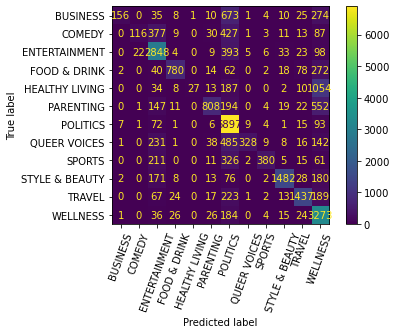

                precision    recall  f1-score   support

      BUSINESS       0.92      0.13      0.23      1197
        COMEDY       0.83      0.11      0.19      1074
 ENTERTAINMENT       0.67      0.83      0.74      3441
  FOOD & DRINK       0.89      0.62      0.73      1268
HEALTHY LIVING       0.96      0.02      0.04      1335
     PARENTING       0.81      0.46      0.59      1758
      POLITICS       0.68      0.97      0.80      7106
  QUEER VOICES       0.95      0.26      0.41      1259
        SPORTS       0.90      0.38      0.53      1011
STYLE & BEAUTY       0.92      0.76      0.83      1962
        TRAVEL       0.84      0.73      0.78      1973
      WELLNESS       0.52      0.91      0.66      3589

      accuracy                           0.69     26973
     macro avg       0.82      0.51      0.54     26973
  weighted avg       0.76      0.69      0.64     26973



In [17]:
# Score results of prediction
result, cm = classifier_metrics(y_pred, y_test, p.id2label, p.classes)

### After dropping rows with emoticons
After training the Naive Bayes classifier to classify headlines into 12 categories, 2 of the major categories (Politics and Entertainment) are showing F1 scores of 0.74 or more. The 3rd major category, Wellness, had F1 score of 0.66, even though it had more learning examples than Entertainment category.

Predictions for minor categories are rather poor, with less than F1 score of less than 0.6. This is as expected, due to insufficient learning examples relative to the large categories.

Accuracy is 0.69; weighted average F1 score is 0.64.

Recall scores for the smaller categories are generally poor e.g. Comedy, Business, Healthy Living, as many articles from the minor classes get mis-classified into the large classes, which results in poor recall for these minor classes.

(Before dropping rows with emoticons, scores are slightly lower by 1 - 4%)

This is a baseline model, without optimising for hyperparameters (such as those for Tfidf). We can expect the overall averaged metrics to improve with further tuning, to become at least 70% or more. 

# (E) Comparing non-transformer models

We compare the performance of the baseline Naive Bayes classifier with other conventional classifiers -- Logistic Regressor, Random Forest and Linear Support Vector Classifier, using the same Tfidf parameters as before.

This is done with 5-fold cross-validation to rule out effects of sampling during partitioning of train, test and validation datasets.

Note: In Google Colab, the notebook crashes repeatedly at this cell with the message "Your session crashed after using all available RAM. If you are interested in access to high-RAM runtimes, you may want to check out Colab Pro." Best to run this notebook locally.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn import metrics
from sklearn.metrics import f1_score


In [20]:
features = features = tfidf.fit_transform(text)#.toarray() # Learn vocabulary and return tfidf matrix

In [23]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys()) 

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [31]:
models = [MultinomialNB(),
          RandomForestClassifier(n_estimators=200, max_depth=10, random_state=RANDOM_STATE),
          LogisticRegression(max_iter=1000), # Increase iterations else convergence warning: "lbfgs failed to converge (status=1)"
          LinearSVC() 
          ]

CV = 3
cv_df = pd.DataFrame(index=range(CV*len(models)))

model_scores =[]
for model in models:
  model_name = model.__class__.__name__
  # accuracies = cross_val_score(model, features, labels, scoring = 'accuracy', cv=CV) # only single metric
  scores = cross_validate(model, features, labels, scoring = ['accuracy', 'f1_weighted'] , cv=CV)
  for fold_idx, score in enumerate(scores):
    model_scores.append((model_name, fold_idx, scores, score))

# 457 min (5fold)
# 20 min (3 fold)
# 7 min

In [61]:
df_models = pd.DataFrame(model_scores, columns=['model', 'fold', 'scores', 'to_drop'])
df_models = df_models[['model', 'scores',]]
df_models.drop_duplicates(subset=['model'], keep='first', inplace=True)
df_models

,model,scores
0,MultinomialNB,"{'fit_time': [0.08173823356628418, 0.07374906539916992, 0.07418322563171387], 'score_time': [0.06333184242248535, 0.06319403648376465, 0.06332898139953613], 'test_accuracy': [0.6328246652133291, 0.6650353694888108, 0.6581985629435188], 'test_f1_weighted': [0.571935164051184, 0.6067439645530752, 0.6007819508560893]}"
4,RandomForestClassifier,"{'fit_time': [18.55028009414673, 15.981350183486938, 18.539215087890625], 'score_time': [1.1440198421478271, 1.1358489990234375, 1.1515347957611084], 'test_accuracy': [0.27210036926636116, 0.2709213863060017, 0.2681467310301871], 'test_f1_weighted': [0.12631165350493004, 0.1245184129307319, 0.1192622730307786]}"
8,LogisticRegression,"{'fit_time': [58.24566602706909, 269.20259308815, 67.61717820167542], 'score_time': [0.10897374153137207, 0.10103297233581543, 0.10352277755737305], 'test_accuracy': [0.7265426880811496, 0.7579525737420474, 0.7355905056392232], 'test_f1_weighted': [0.7104675892456269, 0.7400383999609166, 0.7179575694670833]}"
12,LinearSVC,"{'fit_time': [3.6872520446777344, 3.5884158611297607, 3.4434239864349365], 'score_time': [0.06684398651123047, 0.06357312202453613, 0.06497478485107422], 'test_accuracy': [0.7333051563820795, 0.7650264715042043, 0.7311859052788467], 'test_f1_weighted': [0.7259274541738456, 0.7557517712462404, 0.7231355075684811]}"


In [64]:
def calc_mean_scores(row): 
    a = row['scores']
    for k, v in a.items():
        row['av_accuracy'] = a['test_accuracy'].mean().round(3)
        row['av_f1_weighted'] = a['test_f1_weighted'].mean().round(3)
        return row

df_models = df_models.apply(calc_mean_scores, axis=1)

# a = row['scores'][0]
# for k, v in a.items():
#     x[k] = v
# x

In [65]:
df_models

,model,scores,av_accuracy,av_f1_weighted
0,MultinomialNB,"{'fit_time': [0.08173823356628418, 0.07374906539916992, 0.07418322563171387], 'score_time': [0.06333184242248535, 0.06319403648376465, 0.06332898139953613], 'test_accuracy': [0.6328246652133291, 0.6650353694888108, 0.6581985629435188], 'test_f1_weighted': [0.571935164051184, 0.6067439645530752, 0.6007819508560893]}",0.652,0.593
4,RandomForestClassifier,"{'fit_time': [18.55028009414673, 15.981350183486938, 18.539215087890625], 'score_time': [1.1440198421478271, 1.1358489990234375, 1.1515347957611084], 'test_accuracy': [0.27210036926636116, 0.2709213863060017, 0.2681467310301871], 'test_f1_weighted': [0.12631165350493004, 0.1245184129307319, 0.1192622730307786]}",0.270,0.123
8,LogisticRegression,"{'fit_time': [58.24566602706909, 269.20259308815, 67.61717820167542], 'score_time': [0.10897374153137207, 0.10103297233581543, 0.10352277755737305], 'test_accuracy': [0.7265426880811496, 0.7579525737420474, 0.7355905056392232], 'test_f1_weighted': [0.7104675892456269, 0.7400383999609166, 0.7179575694670833]}",0.740,0.723
12,LinearSVC,"{'fit_time': [3.6872520446777344, 3.5884158611297607, 3.4434239864349365], 'score_time': [0.06684398651123047, 0.06357312202453613, 0.06497478485107422], 'test_accuracy': [0.7333051563820795, 0.7650264715042043, 0.7311859052788467], 'test_f1_weighted': [0.7259274541738456, 0.7557517712462404, 0.7231355075684811]}",0.743,0.735


Based on the above cross-validated tests of the 4 models, LinearSVC scored slightly higher than Logistic Regression, with highest average weighted F1 score of 73.5%. We shall use that for further hyperparameter tuning. 

### Earlier CV with single metric (accuracy), and including text with emoticons

In [ ]:
#5 fold (single metric - accuracy) 
model_scores

[('MultinomialNB', 0, 0.6431079732377185),
 ('MultinomialNB', 1, 0.6609123170190744),
 ('MultinomialNB', 2, 0.6843856276800236),
 ('MultinomialNB', 3, 0.6726674552713293),
 ('MultinomialNB', 4, 0.6701537779092119),
 ('RandomForestClassifier', 0, 0.2665508446383026),
 ('RandomForestClassifier', 1, 0.2664128345408842),
 ('RandomForestClassifier', 2, 0.2705160431761053),
 ('RandomForestClassifier', 3, 0.26815022918823006),
 ('RandomForestClassifier', 4, 0.2682611267189117),
 ('LogisticRegression', 0, 0.7047277566258825),
 ('LogisticRegression', 1, 0.7144388584947509),
 ('LogisticRegression', 2, 0.739316871211001),
 ('LogisticRegression', 3, 0.7281531864557149),
 ('LogisticRegression', 4, 0.7061585095371876),
 ('LinearSVC', 0, 0.7042472184230955),
 ('LinearSVC', 1, 0.7182463403814875),
 ('LinearSVC', 2, 0.7448617477450835),
 ('LinearSVC', 3, 0.728559810734881),
 ('LinearSVC', 4, 0.7000961111932574)]

In [40]:
# Tabulate model scores and find average for each model
scores_raw = pd.DataFrame(model_scores, columns = ['Model', 'Fold', 'Accuracy'])
# round acc to 2 dp
scores_av = scores_raw.groupby(['Model']).mean()
scores_av.loc[:,'Accuracy'] = scores_av['Accuracy'].round(3)
scores_av

,Fold,Accuracy
Model,,
LinearSVC,2,0.719
LogisticRegression,2,0.719
MultinomialNB,2,0.666
RandomForestClassifier,2,0.268


Time taken for 5-fold cross-validation for 4 models: 457 min. This is for a full dataset, including texts with emoticons (previously not discovered).

LinearSVC and Logistic Regression appear to perform the best from this initial cross-validated test, based on accuracy score, giving slightly above 71% accuracy.  

By past experience on a different (albeit much smaller) text dataset, LinearSVC also turned out to be the best classifier among the same 4 models tested 

Random Forest classifier did unusually poorly here, likely due to the relatively low n_estimators value chosen (in part this was an attempt to reduce the total run time required for this initial testing). Also going by past experience, it is possible to achieve >60 - 70% for RF with using n_estimator value of 200 or more (allowing the use of more trees). It may be worthwhile to separately experiment with Random Forest to see if it can be optimised further.

Also noted that accuracy is probably overestimating the model performance. The F1 score is likely to be just slightly lower than the accuracy score, and is a better metric to use, as it captures how well the model balances both precision and recall for each category i.e. correctly classifying a certain category not as the expense of misclassifying other categories. 

In [ ]:
#TODO show classification report and matrix for optimised LinearSVC model


# (F) Optimising LinearSVC
70% accuracy is deemed at average performance for a model. Good models are usually said to perform at 80-90%, with extremely good models at above 90%. 

We will attempt to optimise the LinearSVC model further by adjusting parameters for Tfidf vectorisation. 
Two options are popular for finding the best parameters: grid search and random search. 

Grid search is a systematic exhaustive search of every combination of a set of specified parameter values, and find the best combination that returns the highest accuracy or F1 metric during training. This can take too long. 

Random search takes a random sample of parameter values within a specific search space, and is popular to quickly find optimal parameter values, or at least narrow down to the ballpark values for a start. We use random search below to save on time. 

https://stackoverflow.com/questions/35655701/is-there-a-quicker-way-of-running-gridsearchcv

In [77]:
# Set parameter grid ranges for grid search
# installed imblearn with Anaconda Navigator (restart kernel to import successfully)
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline

param_grid = {
    "features__max_df" : (0.2, 0.4, 0.6), # 0.8
    "features__min_df" : (1, 3, 5), # 10
    "features__ngram_range" : ((1,1), (1,2), ), #(1,4)
    "model__C" : [0.1, 1, 10], #100
    "model__class_weight" : ['balanced'], #None
    # "model__tol" : [1e-4, 1e-5],
}

In [78]:
# Make pipeline
clf = Pipeline(steps=[
    ('features', TfidfVectorizer()),
    ('ros', RandomOverSampler(random_state=RANDOM_STATE),),
    ('model', LinearSVC(random_state=RANDOM_STATE, dual=False)) # ~28K features fr above; use false (135K samples > no. features)
])

# During grid search, had ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
# even though 

https://stackoverflow.com/questions/72101295/python-gridsearchcv-taking-too-long-to-finish-running
- can try out 1 (or low number) of fits to see how long it takes
- 

In [81]:
from sklearn.model_selection import RandomizedSearchCV #GridSearchCV
from pprint import pprint

# grid_search = GridSearchCV(
#     estimator=clf,
#     param_grid=param_grid,
#     random_state=RANDOM_STATE,
#     n_jobs=-1,
#     verbose=1,
#     scoring='f1_weighted',
# )


rand_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    # random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50, # test for 1 to check on time needed (how many combinations to try)
    verbose=1,
    scoring='f1_weighted',
    cv=3, #reduced from 5 fold to 3 to cut down on time;  # by default, uses stratified kfold 
)
print("Doing random search...")
print("Hyperparameters evaluated:")
pprint(param_grid)

# ~3 min for 3 fits (n_iter=1, CV=3)

Doing random search...
Hyperparameters evaluated:
{'features__max_df': (0.2, 0.4, 0.6),
 'features__min_df': (1, 3, 5),
 'features__ngram_range': ((1, 1), (1, 2)),
 'model__C': [0.1, 1, 10],
 'model__class_weight': ['balanced']}


The above parameter ranges will generate 54 possible combinations. To reduce time spent, we will use n_iter = 50, to try the majority (50 of 54) of these possible combinations over 3-folds. 

In [82]:
# Use pipeline to fit to training data
start = datetime.now()
print(start)
rand_search.fit(X_train, y_train)
print(f'Duration: {datetime.now()-start}')

#116 min for 150 fits (cv=3, n_iter=50)


2024-02-11 18:16:06.322702
Fitting 3 folds for each of 50 candidates, totalling 150 fits


Duration: 1:56:29.651777


In [83]:
print(f"Randomized search best estimator:\n", rand_search.best_estimator_)
print(f"Randomized search best parameters:\n", rand_search.best_params_)

Randomized search best estimator:
 Pipeline(steps=[('features', TfidfVectorizer(max_df=0.2, ngram_range=(1, 2))),
                ('ros', RandomOverSampler(random_state=42)),
                ('model',
                 LinearSVC(C=1, class_weight='balanced', dual=False,
                           random_state=42))])
Randomized search best parameters:
 {'model__class_weight': 'balanced', 'model__C': 1, 'features__ngram_range': (1, 2), 'features__min_df': 1, 'features__max_df': 0.2}


In [84]:
# Use these best parameters for vectorization, check what are tfidf features, check which ones are relevant

vect = TfidfVectorizer(max_df=0.2 , min_df=1, ngram_range=(1,2))
X_vect = vect.fit_transform(X_train)
X_vect.shape
len(vect.get_feature_names_out())
print(vect.get_feature_names_out()[900:1000]) # show terms from the raw text, sorted


['10 page' '10 pairs' '10 pamela' '10 parenting' '10 part' '10 people'
 '10 percent' '10 perfect' '10 petitions' '10 photo' '10 photos'
 '10 picks' '10 pictures' '10 picturesque' '10 pieces' '10 pinterest'
 '10 pizza' '10 places' '10 plateau' '10 players' '10 point' '10 points'
 '10 politically' '10 poorest' '10 pop' '10 popular' '10 poses'
 '10 possible' '10 potential' '10 pound' '10 pounds' '10 powerful'
 '10 practical' '10 predictions' '10 premiere' '10 presidential'
 '10 pretty' '10 principles' '10 products' '10 proper' '10 properties'
 '10 proud' '10 psychological' '10 purdue' '10 qualities' '10 queer'
 '10 questions' '10 quick' '10 quotes' '10 racist' '10 random'
 '10 randomized' '10 ranking' '10 reads' '10 real' '10 realities'
 '10 reality' '10 really' '10 reasons' '10 recap' '10 recipes'
 '10 recommendations' '10 red' '10 refreshingly' '10 regional'
 '10 release' '10 remote' '10 renegade' '10 reportedly' '10 republican'
 '10 restaurants' '10 retailers' '10 reuters' '10 richest'

In [85]:
# Use these best parameters for training
clf = Pipeline(steps=[
    ('features', TfidfVectorizer(max_df=0.2 , min_df=1, ngram_range=(1,2))),
    ('ros', RandomOverSampler(random_state=RANDOM_STATE),),
    ('model', LinearSVC(C=1, class_weight='balanced', dual=False)) # random state has no effect when dual=False
])

# Fit the pipeline to data (training the model)
%timeit clf.fit(X_train, y_train)

1min 23s ± 2.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


       y_pred_id         y_pred  y_true_id         y_true
0             11       WELLNESS          5      PARENTING
1              6       POLITICS          6       POLITICS
2             10         TRAVEL         10         TRAVEL
3              6       POLITICS          6       POLITICS
4             10         TRAVEL         10         TRAVEL
...          ...            ...        ...            ...
26968         10         TRAVEL         10         TRAVEL
26969          8         SPORTS         11       WELLNESS
26970          2  ENTERTAINMENT          2  ENTERTAINMENT
26971          5      PARENTING          5      PARENTING
26972          8         SPORTS          8         SPORTS

[26973 rows x 4 columns]


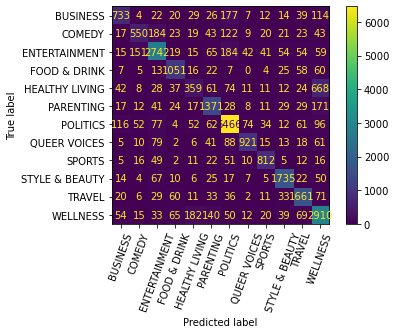

                precision    recall  f1-score   support

      BUSINESS       0.70      0.61      0.65      1197
        COMEDY       0.66      0.51      0.58      1074
 ENTERTAINMENT       0.82      0.80      0.81      3441
  FOOD & DRINK       0.80      0.83      0.81      1268
HEALTHY LIVING       0.50      0.27      0.35      1335
     PARENTING       0.72      0.78      0.75      1758
      POLITICS       0.89      0.91      0.90      7106
  QUEER VOICES       0.83      0.73      0.78      1259
        SPORTS       0.82      0.80      0.81      1011
STYLE & BEAUTY       0.87      0.88      0.88      1962
        TRAVEL       0.80      0.84      0.82      1973
      WELLNESS       0.67      0.81      0.74      3589

      accuracy                           0.79     26973
     macro avg       0.76      0.73      0.74     26973
  weighted avg       0.78      0.79      0.78     26973



In [86]:
# Use trained model to predict on test data
y_pred = clf.predict(X_test)
# Score results of prediction
result, cm = classifier_metrics(y_pred, y_test, p.id2label, p.classes)

### Without text containing emoticons
After adjusting hyperparameters, the accuracy goes up to 0.79 for the test dataset. This is an improvement over the previous accuracy of 0.75 (with all texts with emoticons included, see cell below). All the categories have shown improvement in F1 weighted score. 

The worst performing category continues to be Healthy Living that has the poorest recall. Based on the confusion matrix below, more than 560 of the 1335 Healthy Living articles have been classified under Wellness. This is not surprising as the content matter of these two categories are very close. It might be helpful to consolidate Healthy Living together with Wellness for future training. 

As these metrics are only for a single test dataset, it is worthwhile to perform cross-validation to rule out effects of random sample splitting. 

### With text containing emoticons (Earlier training)

       y_pred_id          y_pred  y_true_id          y_true
0              2   ENTERTAINMENT          2   ENTERTAINMENT
1              9  STYLE & BEAUTY          9  STYLE & BEAUTY
2              5       PARENTING         11        WELLNESS
3              5       PARENTING          5       PARENTING
4              5       PARENTING          5       PARENTING
...          ...             ...        ...             ...
27048          6        POLITICS          6        POLITICS
27049          9  STYLE & BEAUTY          9  STYLE & BEAUTY
27050          7    QUEER VOICES          7    QUEER VOICES
27051          1          COMEDY          1          COMEDY
27052         11        WELLNESS          5       PARENTING

[27053 rows x 4 columns]


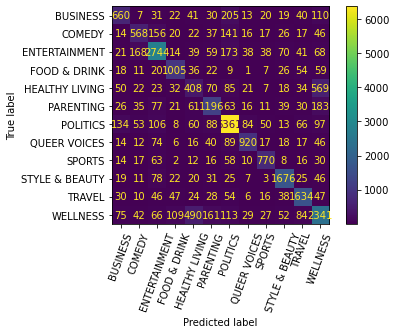

                precision    recall  f1-score   support

      BUSINESS       0.61      0.55      0.58      1198
        COMEDY       0.59      0.53      0.56      1080
 ENTERTAINMENT       0.79      0.79      0.79      3473
  FOOD & DRINK       0.77      0.79      0.78      1268
HEALTHY LIVING       0.33      0.30      0.32      1339
     PARENTING       0.67      0.68      0.68      1758
      POLITICS       0.86      0.89      0.88      7120
  QUEER VOICES       0.79      0.72      0.76      1269
        SPORTS       0.78      0.76      0.77      1016
STYLE & BEAUTY       0.84      0.85      0.85      1963
        TRAVEL       0.79      0.83      0.81      1980
      WELLNESS       0.64      0.65      0.65      3589

      accuracy                           0.75     27053
     macro avg       0.71      0.70      0.70     27053
  weighted avg       0.75      0.75      0.75     27053



In [35]:
# Use trained model to predict on test data
y_pred = clf.predict(X_test)
# Score results of prediction
result, cm = classifier_metrics(y_pred, y_test, p.id2label, p.classes)

After adjusting hyperparameters, the new LinearSVC model appeared to improve in accuracy slightly to 0.79 (or 0.75 for earlier training). 
However, it may be misleading. The result from a single train-test split is affected by some randomness in how the dataset is partitioned into training, validation and test sets, which causes some variability in the data that the model is exposed to during training, even though there was stratified splitting to preserve the representative proportions of the categories across the training, validation and test sets. 

Hence it is better to do cross validation on the entire dataset, using the tuned hyperparameters to average the metrics.

## 5-fold Cross Validation with Optimised Hyperparameters

In [87]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, recall_score, f1_score

scoring = {'prec_micro': 'precision_micro', 
           'rec_micro': make_scorer(recall_score, average='micro'),
           'f1_weighted': make_scorer(f1_score, average='weighted'),
           'accuracy': 'accuracy'}

Pointers on how to choose scoring metrics: 
https://stackoverflow.com/questions/55740220/macro-vs-micro-vs-weighted-vs-samples-f1-score

In [89]:

# Use best parameters for training
clf = Pipeline(steps=[
    ('features', TfidfVectorizer(max_df=0.2 , min_df=1, ngram_range=(1,2))),
    ('ros', RandomOverSampler(random_state=RANDOM_STATE),),
    ('model', LinearSVC(C=1, class_weight='balanced', dual=False)) # random state has no effect when dual=False
])

CV = StratifiedKFold(n_splits=5)

scores = cross_validate(clf, text, labels, scoring = scoring, cv=CV ) # use cross_validate instead for multiple scores

In [90]:
df_score = pd.DataFrame(scores)
df_score

,fit_time,score_time,test_prec_micro,test_rec_micro,test_f1_weighted,test_accuracy
0,103.299859,1.200803,0.762577,0.762577,0.757333,0.762577
1,100.012523,1.195036,0.766906,0.766906,0.762490,0.766906
2,100.917943,1.256803,0.789893,0.789893,0.782452,0.789893
3,95.430550,1.289856,0.771355,0.771355,0.761726,0.771355
4,96.207144,1.342577,0.743920,0.743920,0.736519,0.743920


In [91]:
print(f'Average accuracy = {np.mean(scores["test_accuracy"])}')
print(f'Average precision = {np.mean(scores["test_prec_micro"])}')
print(f'Average recall = {np.mean(scores["test_rec_micro"])}')
print(f'Average f1 (weighted) = {np.mean(scores["test_f1_weighted"])}')

Average accuracy = 0.7669304272772342
Average precision = 0.7669304272772342
Average recall = 0.7669304272772342
Average f1 (weighted) = 0.7601041095786476


Based on the metrics from cross-validation, the average F1 score (weighted) is at 76.0%, while average accuracy is at 76.7%.

The range of weighted F1 score across the different splits is 73 - 78.2%.
Accuracy varied as well from 74 - 79%.

As it is known that LinearSVCs can be trained to be reasonably good models for text classification, it may be worthwhile to repeat randomized search for a different range of parameters. The earlier round of tuning above only tested a small set of values to reduce the optimization time.

In conclusion, a LinearSVC model could be trained to achieve an average weighted F1 of 76% (from 5-fold CV), for classification of 12 categories, with the best hyperparameters tested as: 

 {'model__class_weight': 'balanced', 

 'model__C': 1, 

 'features__ngram_range': (1, 2), 

 'features__min_df': 1, 
 
 'features__max_df': 0.2}

Optional: Since Logistic Regression turned out to perform quite closely to LinearSVC in the initial screen, one can optimise a Logistic Regression classifier as well. 